<a href="https://colab.research.google.com/github/EzaEx/hex-notebooks/blob/main/Copy_of_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs / setup for Colab

In [ ]:
# Install necessary dependencies
!apt-get install -y -q libgl1-mesa-glx libegl1-mesa
!pip install gymnasium[mujoco] imageio[ffmpeg]

# Configure EGL rendering for MuJoCo
import os
os.environ['MUJOCO_GL'] = 'egl'

Reading package lists...
Building dependency tree...
Reading state information...
libegl1-mesa is already the newest version (23.0.4-0ubuntu1~22.04.1).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Agent Class:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, act_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, x):
        raise NotImplementedError

    def get_action(self, state):
      mean = self.actor(state)
      std = self.log_std.exp()
      dist = Normal(mean, std)
      action = dist.sample()
      log_prob = dist.log_prob(action).sum(dim=-1)
      return action, log_prob


    def get_value(self, state):
        return self.critic(state)

    def evaluate_actions(self, states, actions):
        mean = self.actor(states)
        std = self.log_std.exp()
        dist = Normal(mean, std)
        log_probs = dist.log_prob(actions).sum(axis=-1)
        entropy = dist.entropy().sum(axis=-1)
        values = self.critic(states).squeeze()
        return log_probs, entropy, values


In [ ]:
# example random-agent
class RandomAgent:
    def __init__(self, obs_dim, act_dim):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.total_rewards = []

    def select_action(self, state, explore=True):
        return np.random.uniform(low=-1.0, high=1.0, size=self.act_dim)

    def train(self, reward):
        self.total_rewards.append(reward)

In [ ]:
class PPOAgent:
    def __init__(self, obs_dim, act_dim, lr=3e-4, clip_eps=0.2, gamma=0.99, lam=0.95):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.clip_eps = clip_eps
        self.gamma = gamma
        self.lam = lam
        self.policy = ActorCritic(obs_dim, act_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.total_rewards = []

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            action, log_prob = self.policy.get_action(state_tensor)
        return action.numpy(), log_prob.item()


    def compute_gae(self, rewards, values, dones, next_value):
        advantages = []
        gae = 0
        values = values + [next_value]
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        return advantages

    def train_step(self, states, actions, log_probs_old, returns, advantages, epochs=10):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        log_probs_old = torch.tensor(log_probs_old, dtype=torch.float32)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages, dtype=torch.float32)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(epochs):
            log_probs, entropy, values = self.policy.evaluate_actions(states, actions)
            ratios = (log_probs - log_probs_old).exp()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = nn.functional.mse_loss(values, returns)
            #loss = policy_loss + 0.5 * value_loss - 0.01 * entropy.mean()
            loss = policy_loss + 0.5 * value_loss - 0.05 * entropy.mean()


            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


Evaluation Function:

In [ ]:
# evaluation function (records a full simulated trial of the agent)
def evaluate(agent, env, seed = 42, max_steps=10000, save_path='humanoid_demo.mp4'):
    frames = []
    obs, _ = env.reset(seed=seed)

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        # Modified line: Unpack the tuple returned by select_action
        action, _ = agent.select_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    env.close()
    imageio.mimsave(save_path, frames, fps=30)
    display(Video(save_path, embed=True))

In [ ]:
def train_and_evaluate(agent, env, episodes=1000, max_steps=200, update_every=20):
    batch_states, batch_actions, batch_log_probs = [], [], []
    batch_returns, batch_advantages = [], []
    smoothed_training_curve = []

    for episode in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []

        for _ in range(max_steps):
            state_tensor = torch.tensor(obs, dtype=torch.float32)
            value = agent.policy.get_value(state_tensor).item()
            action, log_prob = agent.select_action(obs)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_probs.append(log_prob)
            values.append(value)

            obs = next_obs
            ep_reward += reward
            if done:
                break

        with torch.no_grad():
            next_value = agent.policy.get_value(torch.tensor(obs, dtype=torch.float32)).item()

        advantages = agent.compute_gae(rewards, values, dones, next_value)
        returns = [a + v for a, v in zip(advantages, values)]

        batch_states += states
        batch_actions += actions
        batch_log_probs += log_probs
        batch_returns += returns
        batch_advantages += advantages
        agent.total_rewards.append(ep_reward)

        # Update policy every `update_every` episodes
        if (episode + 1) % update_every == 0:
            agent.train_step(batch_states, batch_actions, batch_log_probs, batch_returns, batch_advantages)
            batch_states, batch_actions, batch_log_probs = [], [], []
            batch_returns, batch_advantages = [], []

            smoothed = sum(agent.total_rewards[episode - update_every : episode])/update_every
            smoothed_training_curve.append((episode, smoothed))
            print(f"Episode {episode+1}, Reward(avg): {smoothed:.2f}")

    return smoothed_training_curve


Main:

In [ ]:
# sets up a fresh gymnasium environment, returns observation and action dimensions needed to setup agents
def make_env(env_name, seed = 42):
    env = gym.make(env_name, render_mode='rgb_array')
    env.reset(seed=seed)

    return env, env.observation_space.shape[0], env.action_space.shape[0]

Episode 10, Reward(avg): 0.00
Episode 20, Reward(avg): 60.92
Episode 30, Reward(avg): 74.86
Episode 40, Reward(avg): 66.34
Episode 50, Reward(avg): 50.39
Episode 60, Reward(avg): 64.52
Episode 70, Reward(avg): 75.92
Episode 80, Reward(avg): 75.82
Episode 90, Reward(avg): 65.24
Episode 100, Reward(avg): 68.80
Episode 110, Reward(avg): 76.89
Episode 120, Reward(avg): 64.88
Episode 130, Reward(avg): 65.92
Episode 140, Reward(avg): 70.23
Episode 150, Reward(avg): 74.52
Episode 160, Reward(avg): 59.08
Episode 170, Reward(avg): 62.31
Episode 180, Reward(avg): 78.23
Episode 190, Reward(avg): 59.68
Episode 200, Reward(avg): 76.20
Episode 210, Reward(avg): 76.61
Episode 220, Reward(avg): 67.07
Episode 230, Reward(avg): 62.75
Episode 240, Reward(avg): 64.96
Episode 250, Reward(avg): 70.29
Episode 260, Reward(avg): 55.73
Episode 270, Reward(avg): 66.59
Episode 280, Reward(avg): 62.39
Episode 290, Reward(avg): 75.25
Episode 300, Reward(avg): 71.30
Episode 310, Reward(avg): 74.96
Episode 320, Rewar

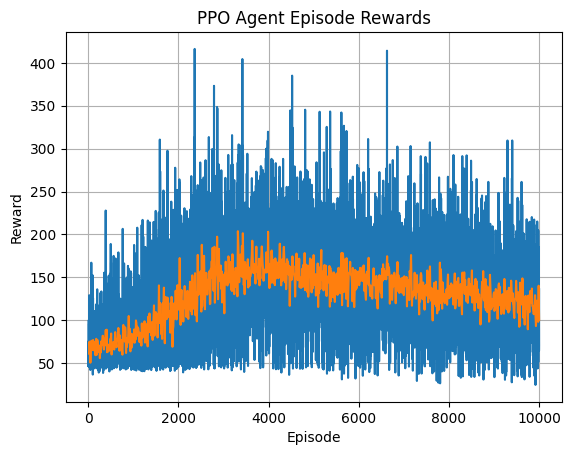

In [ ]:
import gymnasium as gym
import imageio
import numpy as np
from IPython.display import Video, display
import matplotlib.pyplot as plt

# environment set-up

#ENV_NAME = "Pendulum-v1"
ENV_NAME = "Humanoid-v5"
env, obs_dim, act_dim = make_env(ENV_NAME)


# # run the random agent

# agent = RandomAgent(obs_dim, act_dim)
# evaluate(agent, env, save_path='random_agent_demo.mp4')


# # run the do-nothing agent

# env, _, _ = make_env(ENV_NAME) # re-build environment before each video-capture session

# agent = Agent(obs_dim, act_dim)
# evaluate(agent, env)

# --- Main ---
agent = PPOAgent(obs_dim, act_dim, lr = 5e-5, clip_eps = 0.05, lam = 0.97)
s = train_and_evaluate(agent, env, episodes=10000, max_steps = 10000, update_every=10)
print(s)
# --- Plot Results ---
plt.plot(agent.total_rewards)
plt.title("PPO Agent Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

x_val = [x[0] for x in s[1:]]
y_val = [x[1] for x in s[1:]]
plt.plot(x_val, y_val)

plt.grid(True)
plt.show()

evaluate(agent, env)